# Analysis of VICTree output tree matrix

In [55]:
import h5py
import numpy as np
import numpy.linalg as la
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import time
from treesampling.algorithms import random_spanning_tree_log, CastawayRST, colbourn_rst, kirchoff_rst, wilson_rst
from treesampling.algorithms.castaway_legacy import random_spanning_tree_log as rst_legacy
from treesampling.algorithms.castaway_legacy import castaway_rst

from treesampling.utils.graphs import reset_adj_matrix, tree_to_newick, tuttes_tot_weight, graph_weight, \
    normalize_graph_weights, enumerate_rooted_trees, cayleys_formula
from treesampling.utils.visualization import plot_logweights_heatmap

In [7]:
# load h5 file
# this is partial run with wilson algorithm (matrix where wilson gets stuck)
vic_out = h5py.File("/Users/zemp/phd/scilife/victree-experiments/cnasim_performance/hg38_1_N200Z6F1/victree_out_wilsonqt/victree.out.h5ad", 'r')

## with victree-legacy sampling
# vic_out = h5py.File("/Users/zemp/phd/scilife/victree-experiments/cnasim_performance/data/hg38_N100Z6F0.1C0.02/victree_out_legacyqt/victree.out.h5ad", 'r')
# vic_out = h5py.File("/Users/zemp/phd/scilife/victree-experiments/SA501X3F/victree-out/K12/victree.out.h5ad", 'r')
graph_matrix = vic_out['uns']['victree-tree-graph'][:]
# tempering:
# graph_matrix = graph_matrix / 50
# graph_matrix = np.exp(graph_matrix)

In [8]:
import itertools
K = graph_matrix.shape[0]
ss = 10000
graph = nx.complete_graph(K, create_using=nx.DiGraph)
for u, v in itertools.product(range(K), repeat=2):
    if v == 0 or u == v:
        graph_matrix[u, v] = -np.inf
        if (u, v) in graph.edges():
            graph.remove_edge(u, v)
graph = reset_adj_matrix(graph, graph_matrix)
nx.to_numpy_array(graph)

array([[           -inf, -5.53106880e+01, -4.08155518e+02,
        -5.04498444e+02, -1.07182263e+03, -1.53380013e+01,
        -2.17641748e+03, -5.99199463e+03, -1.53379974e+01,
        -1.53379974e+01],
       [           -inf,            -inf, -4.41990509e+02,
        -5.26375183e+02, -1.08963806e+03, -4.22997169e+01,
        -2.17801099e+03, -5.87612939e+03, -4.22997169e+01,
        -4.22997169e+01],
       [           -inf, -3.90922577e+02,            -inf,
        -6.86142212e+02, -1.20311511e+03, -3.63944427e+02,
        -2.15428101e+03, -4.73057617e+03, -3.63944427e+02,
        -3.63944427e+02],
       [           -inf, -3.16273468e+02, -5.54020874e+02,
                   -inf, -1.07047791e+03, -2.95583862e+02,
        -2.24310938e+03, -3.63921899e+03, -2.95583862e+02,
        -2.95583862e+02],
       [           -inf, -1.09302710e+03, -1.23187378e+03,
        -1.16125269e+03,            -inf, -1.07935327e+03,
        -2.24841187e+03, -3.71356372e+03, -1.07935327e+03,
        -1.

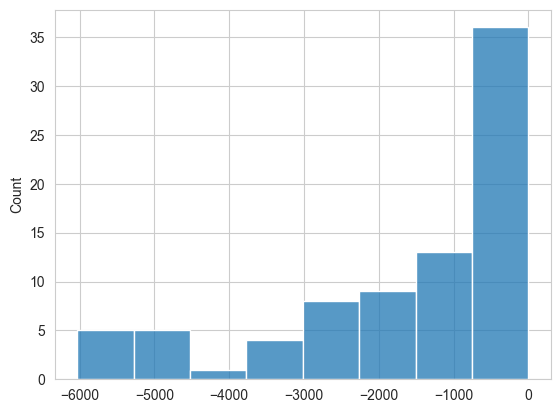

In [9]:
# histogram
g = sns.histplot(graph_matrix[~np.isinf(graph_matrix)])

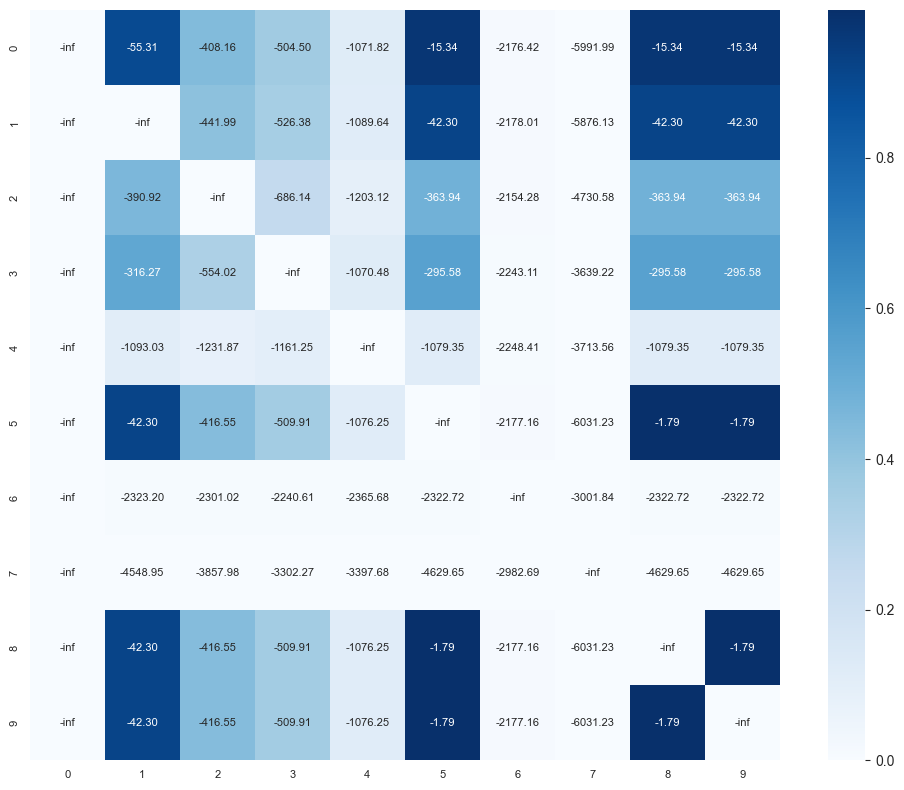

In [10]:
# heatmap
f, ax = plt.subplots(figsize=(10, 8)) ## here increased figsize
plot_logweights_heatmap(nx.to_numpy_array(graph), ax=ax, color_tempering=500)
f.tight_layout()


/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_85464/1438550257.py:3: RuntimeWarning: invalid value encountered in subtract
  graph_matrix_lognorm = graph_matrix - sp.logsumexp(graph_matrix, axis=0, keepdims=True)


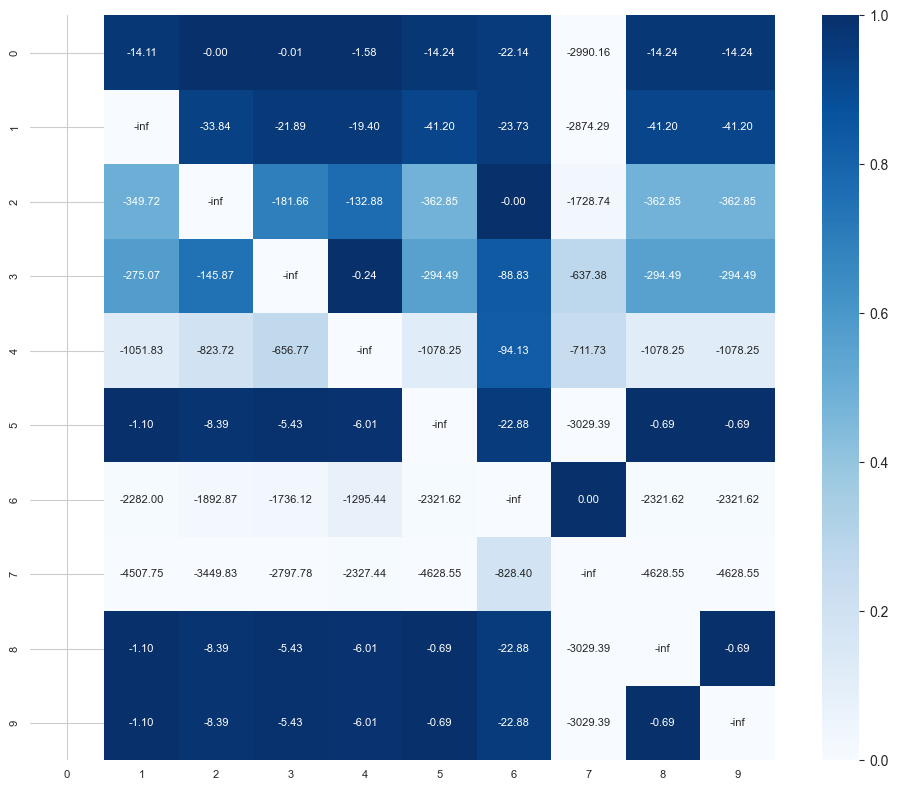

In [29]:
import scipy.special as sp
#normalize with logsumexp and plot again
graph_matrix_lognorm = graph_matrix - sp.logsumexp(graph_matrix, axis=0, keepdims=True)
f, ax = plt.subplots(figsize=(10, 8)) ## here increased figsize
plot_logweights_heatmap(graph_matrix_lognorm, ax=ax, color_tempering=500)
f.tight_layout()


In [42]:
# condition number
from treesampling.utils.graphs import mat_minor, laplacian
exp_matrix = np.exp(graph_matrix_lognorm)
exp_graph = reset_adj_matrix(graph, exp_matrix)
L = laplacian(exp_matrix)
L1r = mat_minor(L, row=0, col=0)
# print(L1r)
cn = la.cond(L1r)
print(f"Condition number on L1r matrix: {cn}")
print(f"Determinant of L1r: {la.det(L1r)}")

Condition number on L1r matrix: 3179234.8942704485
Determinant of L1r: 1.472635778664305e-06


In [34]:
edge_freq_castaway = np.zeros((K, K))
trees = []
for i in range(ss):
    tree = rst_legacy(graph, root=0)
    for e in tree.edges():
        edge_freq_castaway[e] += 1

    trees.append(tree)


/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_85464/829309106.py:4: DeprecationWarning: Use the new function castaway_rst with log_probs=True
  tree = rst_legacy(graph, root=0)
/Users/zemp/PycharmProjects/treesampling/src/treesampling/algorithms/castaway_legacy.py:398: RuntimeWarning: invalid value encountered in subtract
  adj_mat = adj_mat - np.logaddexp.reduce(adj_mat, axis=axis, keepdims=True)


<Axes: >

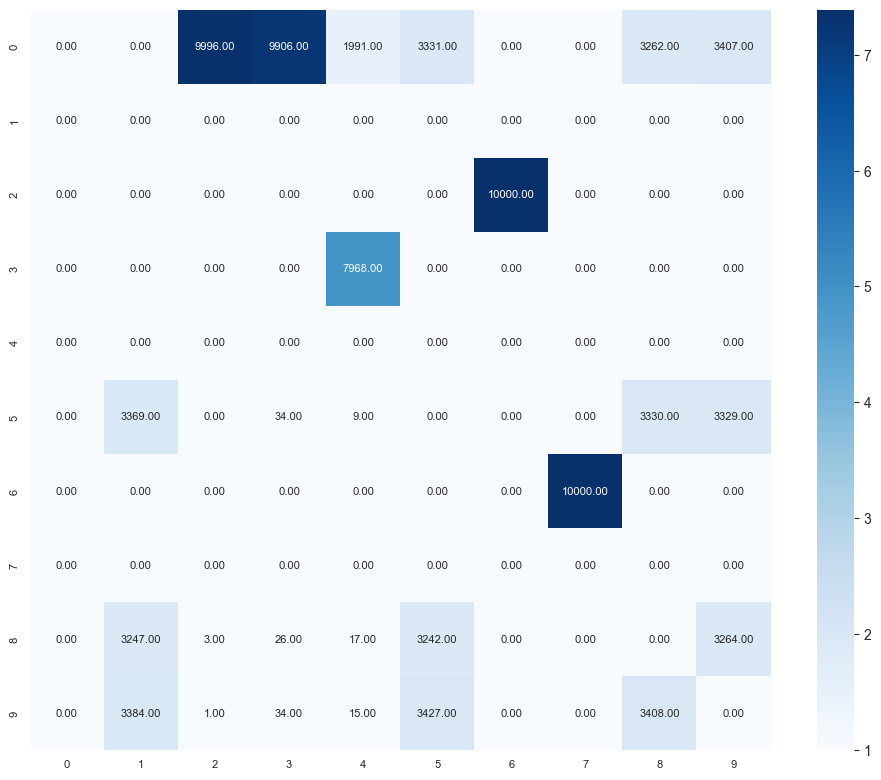

In [35]:
plot_logweights_heatmap(edge_freq_castaway, color_tempering=5000)

In [48]:
# check the total weight of all unique, sampled trees
tot_weight = 0
weights = []
seen_trees = set()
for t in trees:
    tnwk = tree_to_newick(t)
    if tnwk not in seen_trees:
        seen_trees.add(tnwk)
        w = np.exp(graph_weight(t, log_probs=True))
        weights.append(w)
        tot_weight += w

In [56]:
print(f"Total weight of trees (empirical) {tot_weight}")
graph_norm = normalize_graph_weights(graph, log_probs=True)
exp_matrix = np.exp(nx.to_numpy_array(graph_norm))
exp_matrix[:, np.all(exp_matrix == 0, axis=0)] = 1.
exp_matrix[np.diag_indices(K)] = 1.
exp_graph = reset_adj_matrix(graph, exp_matrix)
tuttes_weight = tuttes_tot_weight(exp_graph, root=0)
print(f"Total weight of trees (Tutte) {tuttes_weight}")
print(f"difference: {tuttes_weight - tot_weight} must be at least smaller than {1 / ss} (1/sample_size)")
print(f"number of unique trees: {len(seen_trees)} out of {cayleys_formula(K)}")

Total weight of trees (empirical) 1.4515918122020982e-06
Total weight of trees (Tutte) 1.472635778664305e-06
difference: 2.1043966462206737e-08 must be at least smaller than 0.0001 (1/sample_size)
number of unique trees: 131 out of 100000000


Text(0.5, 1.0, 'Cumulative sum of weights')

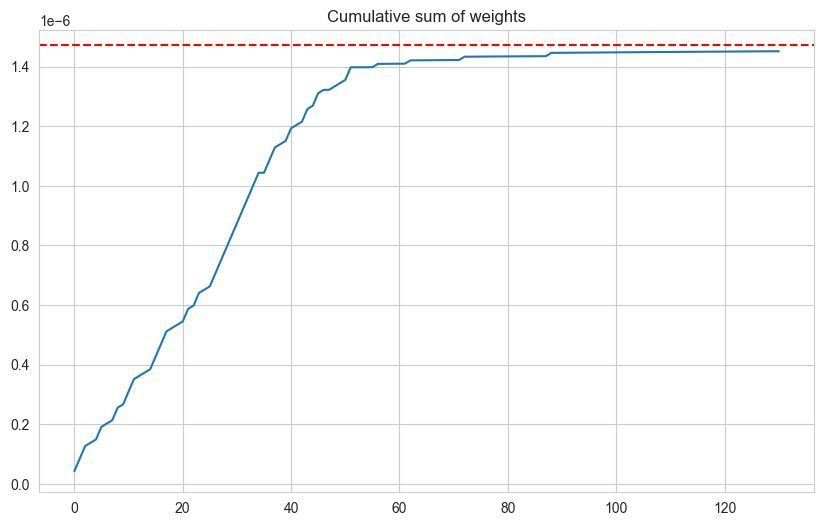

In [51]:
# plot the cumulative sum of the weights from the castaway algorithm
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.cumsum(weights))
ax.axhline(tuttes_weight, color='r', linestyle='--')
ax.set_title("Cumulative sum of weights")



In [17]:
# brute force total weight computation
# all_trees = enumerate_rooted_trees(K, 0, exp_graph)
# brute_force_tot_weight = np.sum([graph_weight(t) for t in all_trees])
# print(f"Total weight of trees (brute force) {brute_force_tot_weight}")

In [38]:
tot_weight_wilson = 0
edge_freq_wilson = np.zeros((K, K))
seen_trees = set()
for i in range(20):
    tree = wilson_rst(graph, root=0, log_probs=True)
    tnwk = tree_to_newick(tree)
    if tnwk not in seen_trees:
        seen_trees.add(tnwk)
        tot_weight += np.exp(graph_weight(tree, log_probs=True))
    for e in tree.edges():
        edge_freq_wilson[e] += 1


In [39]:
print(f"Total weight of trees (empirical - Wilson) {tot_weight}")

Total weight of trees (empirical - Wilson) 1.9929407178958426e-06


<Axes: >

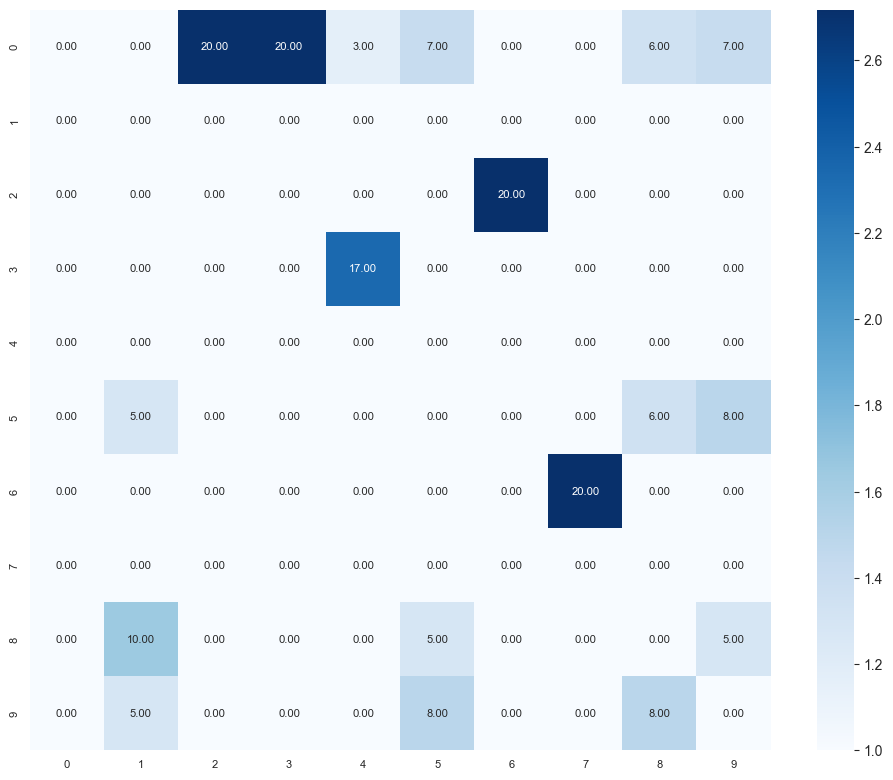

In [40]:
plot_logweights_heatmap(edge_freq_wilson, color_tempering=20)

In [21]:
exp_graph.edges() # check that it doesn't contain self loops and nodes to root arcs

OutEdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 0), (1, 1), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 0), (2, 2), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 0), (3, 3), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 0), (4, 4), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 0), (5, 5), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 7), (6, 8), (6, 9), (6, 0), (6, 6), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 8), (7, 9), (7, 0), (7, 7), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 9), (8, 0), (8, 8), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 0), (9, 9)])

In [45]:
exp_graph.remove_edges_from([(u, v) for u, v in exp_graph.edges() if exp_graph.edges()[u, v]['weight'] == 0])
edge_freq_kirchoff = np.zeros((K, K))
for s in range(ss):
    tree = kirchoff_rst(exp_graph, root=0, log_probs=False)
    for e in tree.edges():
        edge_freq_kirchoff[e] += 1

<Axes: >

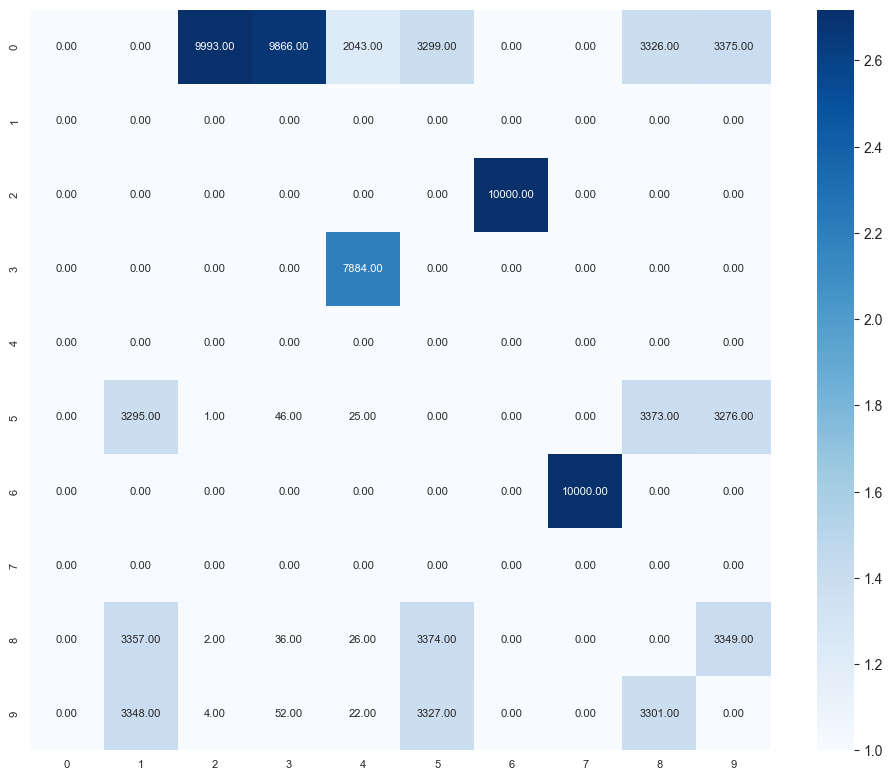

In [46]:
plot_logweights_heatmap(edge_freq_kirchoff, color_tempering=ss)

Text(0.5, 0.98, 'Edge frequency comparison')

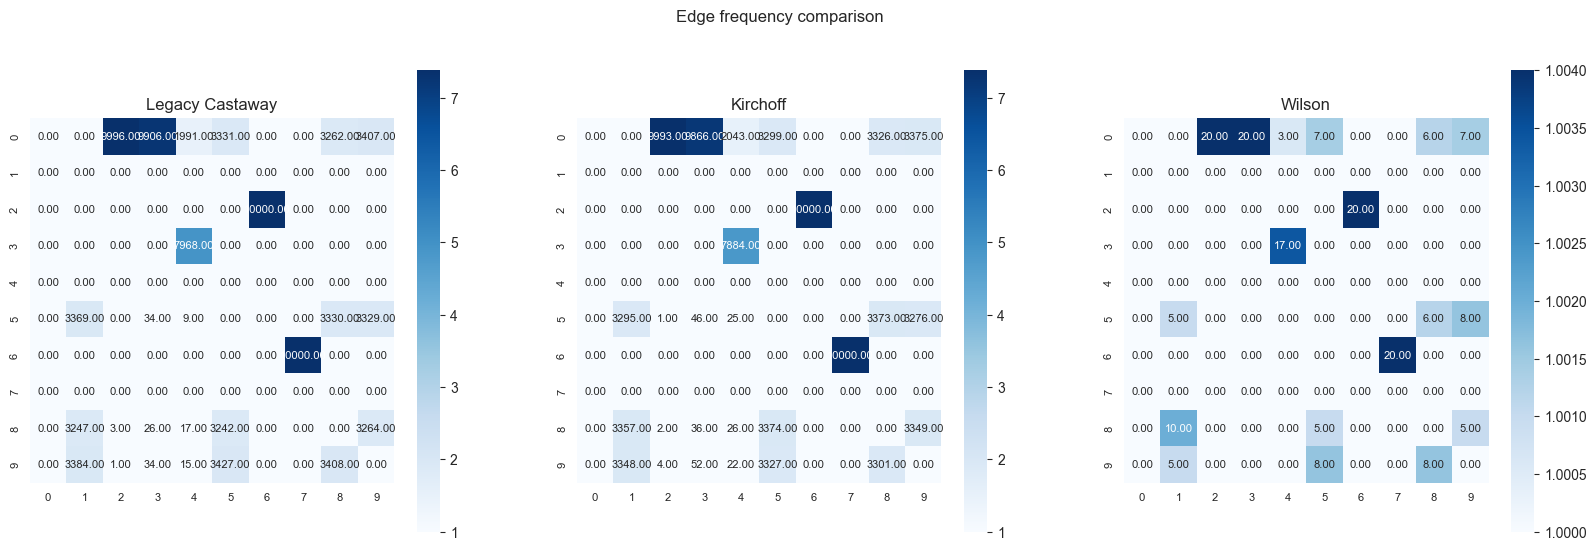

In [47]:
# print all three next to eachother
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].set_title("Legacy Castaway")
plot_logweights_heatmap(edge_freq_castaway, color_tempering=5000, ax=ax[0])
ax[1].set_title("Kirchoff")
plot_logweights_heatmap(edge_freq_kirchoff, color_tempering=5000, ax=ax[1])
ax[2].set_title("Wilson")
plot_logweights_heatmap(edge_freq_wilson, color_tempering=5000, ax=ax[2])
fig.suptitle("Edge frequency comparison")




/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_72603/2368970600.py:3: RuntimeWarning: invalid value encountered in subtract
  weights_norm = graph_matrix - sp.logsumexp(graph_matrix, axis=0, keepdims=True)


Text(0.5, 1.0, 'Normalized exp-weights')

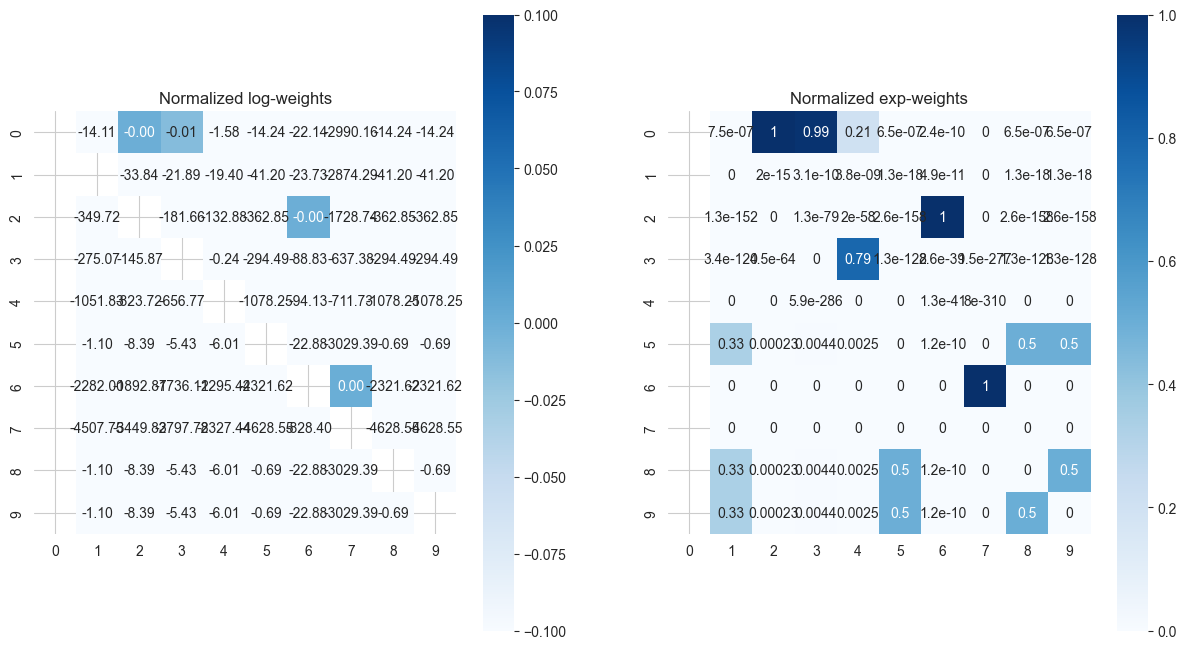

In [13]:
import scipy.special as sp
# normalize over column and take exponential. check if the matrix is similar to the edges count
weights_norm = graph_matrix - sp.logsumexp(graph_matrix, axis=0, keepdims=True)
weights_exp = np.exp(weights_norm)
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(weights_norm, annot=weights_norm, cmap='Blues', fmt='.2f', square=True, ax=axs[0])
axs[0].set_title("Normalized log-weights")
sns.heatmap(weights_exp, annot=weights_exp, cmap='Blues', square=True, ax=axs[1])
axs[1].set_title("Normalized exp-weights")

In [17]:
graph.edges

OutEdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 0), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 1), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 2), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 3), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 4), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (5, 5), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 7), (6, 8), (6, 9), (6, 6), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 8), (7, 9), (7, 7), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 9), (8, 8), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)])

In [19]:
clb_edge_counts = np.zeros((K, K))
clb_trees = []
reduced_graph = graph.copy()
reduced_graph.remove_edges_from([(u, v) for u, v in graph.edges() if v == 0 or u == v])
for i in range(ss):
    # tree = colbourn_rst(graph, root=0, log_probs=True)
    tree = kirchoff_rst(graph, root=0, log_probs=True)
    for e in tree.edges():
        clb_edge_counts[e] += 1
    clb_trees.append(tree)

/Users/zemp/PycharmProjects/treesampling/src/treesampling/utils/math.py:50: RuntimeWarning: invalid value encountered in divide
  return arr / np.sum(arr, axis=axis, keepdims=True)
/Users/zemp/PycharmProjects/treesampling/src/treesampling/algorithms/__init__.py:63: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio = aa / a


IndexError: pop from empty list

Text(0.5, 1.0, 'Exponentiated log weights')

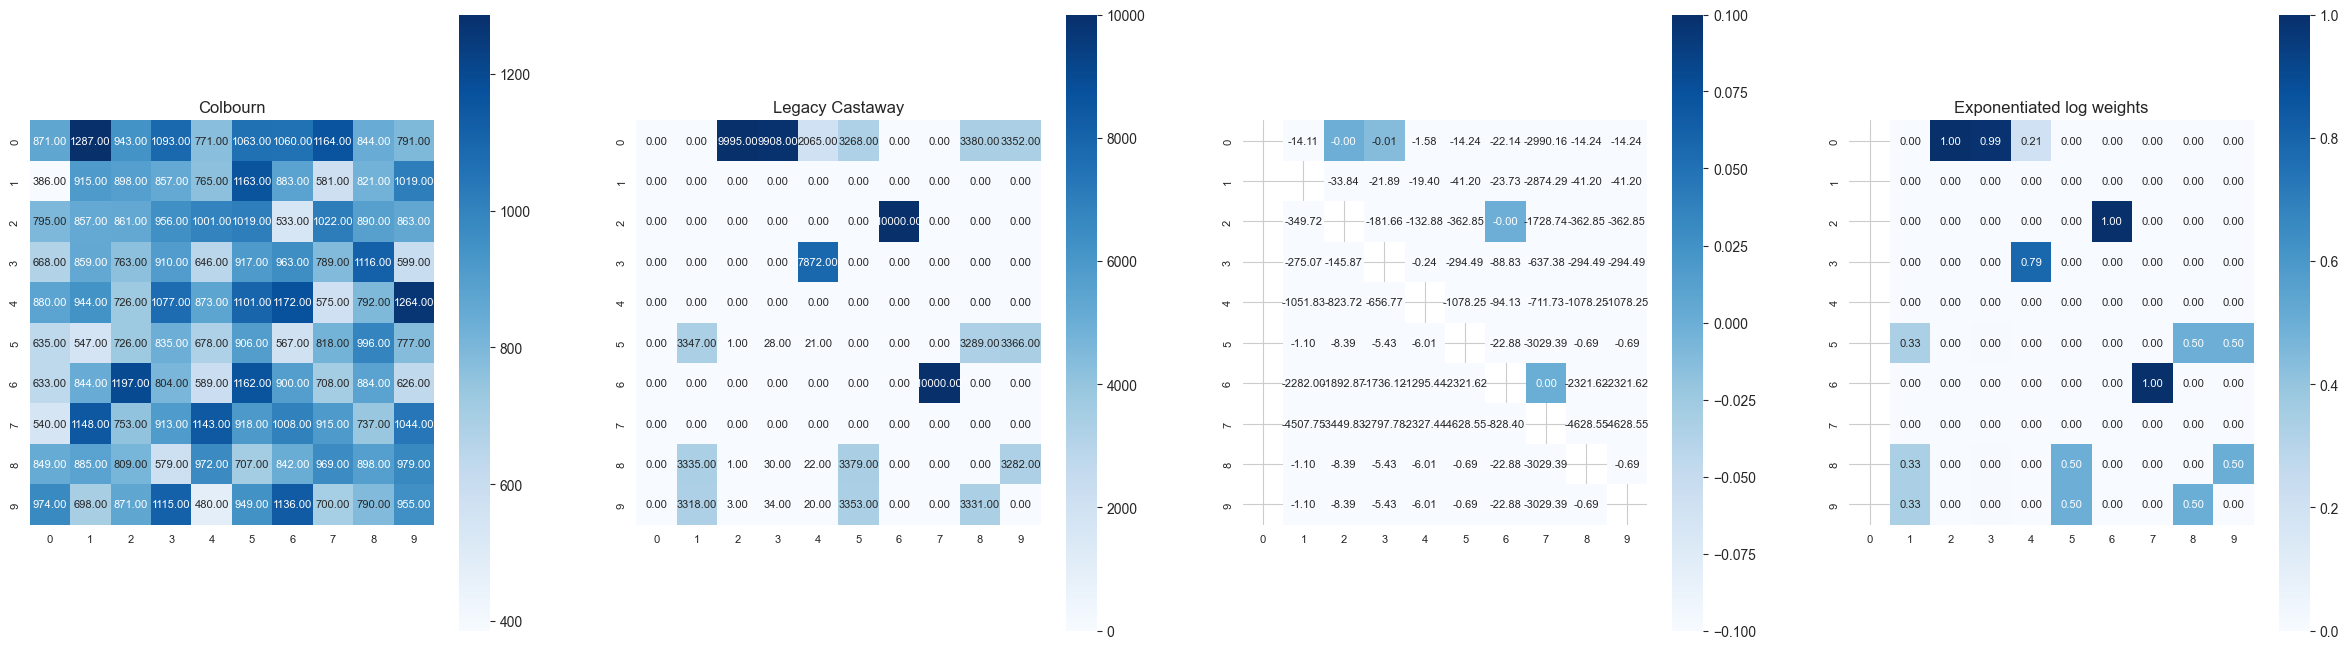

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(30, 8), dpi=100)
sns.heatmap(clb_edge_counts, annot=clb_edge_counts.astype(int), cmap='Blues', fmt='.2f', square=True, ax=axs[0], annot_kws={"size": 8})
axs[0].tick_params(axis='both', labelsize=8)
axs[0].set_title("Colbourn")
sns.heatmap(edges_count, annot=edges_count.astype(int), cmap='Blues', fmt='.2f', square=True, ax=axs[1], annot_kws={"size": 8})
axs[1].tick_params(axis='both', labelsize=8)
axs[1].set_title("Legacy Castaway")
sns.heatmap(weights_norm, annot=weights_norm, cmap='Blues', fmt='.2f', square=True, ax=axs[2], annot_kws={"size": 8})
axs[2].tick_params(axis='both', labelsize=8)
axs[3].set_title("Norm log weights")
sns.heatmap(weights_exp, annot=weights_exp, cmap='Blues', fmt='.2f', square=True, ax=axs[3], annot_kws={"size": 8})
axs[3].tick_params(axis='both', labelsize=8)
axs[3].set_title("Exponentiated log weights")


In [6]:
# draw 500 trees and save them in dict
sample = {}
legacy_times = []
for i in range(ss):
    tree = None
    miss = 0
    start = time.time()
    while tree is None and miss < 20:
        try:
            tree = rst_legacy(graph, root=0)
        except ValueError as e:
            miss += 1
            tree = None

    if miss > 20:
        print(f"FAIL")
        continue
    elif miss > 0:
        print(f"WARN: Missed {miss} times")
    else:
        print(f"OK")

    legacy_times.append(time.time() - start)
    tnwk = tree_to_newick(tree)
    if tnwk not in sample:
        sample[tnwk] = 0
    sample[tnwk] += 1

sorted(sample.items(), key=lambda a: a[1], reverse=True)



/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_89570/290808423.py:10: DeprecationWarning: Use the new function castaway_rst with log_probs=True
  tree = rst_legacy(graph, root=0)


OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
O

[('((6)2,(4,7)3,(1,8,9)5)0', 24),
 ('(((7)6)2,(4)3,(1,8,9)5)0', 22),
 ('(((7)6)2,(4)3,(1,(8)9)5)0', 19),
 ('((6)2,(4,7)3,(1,(9)8)5)0', 15),
 ('((6)2,(4,7)3,(1,(8)5)9)0', 12),
 ('(((7)6)2,(4)3,((1,9)5)8)0', 12),
 ('((6)2,(4,7)3,(1,(8)9)5)0', 11),
 ('(((7)6)2,(4)3,(8,(1)9)5)0', 10),
 ('(((7)6)2,(4)3,(1,5,9)8)0', 10),
 ('((6)2,(4,7)3,(1,5,8)9)0', 10),
 ('(1,(6)2,(4,7)3,(8,9)5)0', 9),
 ('(((7)6)2,(4)3,(1,(8)5)9)0', 9),
 ('(((7)6)2,(4)3,((1,8)5)9)0', 8),
 ('((6)2,(4,7)3,(1,(9)5)8)0', 8),
 ('((6)2,(4,7)3,(8,(1)9)5)0', 8),
 ('(((7)6)2,(4)3,(5,(1)9)8)0', 8),
 ('((6)2,(4,7)3,(((1)9)5)8)0', 8),
 ('((6)2,(4,7)3,(1,5,9)8)0', 7),
 ('(((7)6)2,(4)3,((1,5)8)9)0', 7),
 ('(((7)6)2,(4)3,((1)5,9)8)0', 7),
 ('(((7)6)2,(4)3,((1,8)9)5)0', 7),
 ('((6)2,(4,7)3,((1,5)8)9)0', 6),
 ('((6)2,(4,7)3,((1,9)5)8)0', 6),
 ('(((7)6)2,(4)3,((1)8,9)5)0', 6),
 ('((6)2,(7)3,4,(1,8,9)5)0', 6),
 ('(((7)6)2,3,4,((1)5,9)8)0', 5),
 ('(((7)6)2,(4)3,(((1)9)5)8)0', 5),
 ('(((7)6)2,3,4,(1,(8)9)5)0', 5),
 ('((6)2,(4,7)3,((1,8)9)5)0', 

In [7]:
# draw 100 trees and save them in dict
sample = {}
for i in range(ss):
    miss = 0
    tree = None
    while tree is None and miss < 20:
        try:
            sampler = CastawayRST(graph, root=0, log_probs=True, trick=True)
            tree = sampler.sample_tree()
        except ValueError as e:
            miss += 1
            tree = None
        if miss > 20:
            print(f"FAIL")
            continue
    tnwk = tree_to_newick(tree)
    if tnwk not in sample:
        sample[tnwk] = 0
    sample[tnwk] += 1

sorted(sample.items(), key=lambda a: a[1], reverse=True)

edge 6 -> 6 has weight 1.0, all other edges in node 6 will be set to 0.
edge 7 -> 7 has weight 1.0, all other edges in node 7 will be set to 0.
/Users/zemp/PycharmProjects/treesampling/src/treesampling/utils/math.py:48: RuntimeWarning: invalid value encountered in subtract
  return arr - sp.logsumexp(arr, axis=axis, keepdims=True)
Error computing Ry(u) = 1 / (1 - Ry_1(u))
Ry_1(u) = nan
edge 6 -> 6 has weight 1.0, all other edges in node 6 will be set to 0.
edge 7 -> 7 has weight 1.0, all other edges in node 7 will be set to 0.
Error computing Ry(u) = 1 / (1 - Ry_1(u))
Ry_1(u) = nan
edge 6 -> 6 has weight 1.0, all other edges in node 6 will be set to 0.
edge 7 -> 7 has weight 1.0, all other edges in node 7 will be set to 0.
Error computing Ry(u) = 1 / (1 - Ry_1(u))
Ry_1(u) = nan
edge 6 -> 6 has weight 1.0, all other edges in node 6 will be set to 0.
edge 7 -> 7 has weight 1.0, all other edges in node 7 will be set to 0.
Error computing Ry(u) = 1 / (1 - Ry_1(u))
Ry_1(u) = nan
edge 6 -> 6

AttributeError: 'NoneType' object has no attribute 'is_directed'

In [8]:
vic_out.uns['victree-tree-newick']

AttributeError: 'File' object has no attribute 'uns'

In [21]:
vic_out.uns['victree-tree-probs']

array([nan, nan], dtype=float32)

In [8]:
from treesampling.algorithms import wilson_rst
import time
# NOTE: this takes too long
# draw 20 trees and compute avg time
times = []
for i in range(20):
    start = time.time()
    tree = wilson_rst(graph, root=0, log_probs=True)
    times.append(time.time() - start)


In [9]:
print(f"Average time Wilson (seconds for one tree): {np.mean(times):.5f} +- {np.std(times):.5f}")
# against legacy:
print(f"Average time Legacy Castaway (seconds for one tree): {np.mean(legacy_times):.5f} +- {np.std(legacy_times):.5f}")

Average time Wilson (seconds for one tree): 5.06252 +- 5.58623
Average time Legacy Castaway (seconds for one tree): 0.00420 +- 0.00145


In [12]:
from treesampling.utils.graphs import tuttes_tot_weight
# determinant computation - not possible with log graph..
# try with preprocessing of the graph (filter out < -thresh and set to -inf)
tot_weight_estimate = tuttes_tot_weight(graph, root=0)
print(tot_weight_estimate)

nan


In [13]:
sample = {}
for i in range(ss):
    tree = kirchoff_rst(graph, root=0, log_probs=True)
    tnwk = tree_to_newick(tree)
    if tnwk not in sample:
        sample[tnwk] = 0
    sample[tnwk] += 1

sorted(sample.items(), key=lambda a: a[1], reverse=True)

IndexError: pop from empty list

In [36]:
from treesampling.utils.graphs import normalize_graph_weights
matrix = nx.to_numpy_array(graph)
matrix[:, 0] = 0.
matrix[0, 0] = -np.inf
print(matrix)
kirch_graph = reset_adj_matrix(graph, matrix)
# normalize graph weights
kirch_graph = normalize_graph_weights(kirch_graph, log_probs=True)
min_log_weight = np.log(np.nextafter(0, 1))
matrix[matrix < min_log_weight] = -np.inf
W = np.exp(matrix)
print(W)
print(np.all(np.isclose(W, 0.), axis=1))
W[:, np.all(np.isnan(W), axis=0)] = 1.
kirch_graph = reset_adj_matrix(kirch_graph, W)
kirch_graph = normalize_graph_weights(kirch_graph, log_probs=False)
nx.to_numpy_array(kirch_graph)
# FIXME: find a way of preprocessing this matrix for kirchoff/colbourn algorithms


[[           -inf -5.53106880e+01 -4.08155518e+02 -5.04498444e+02
  -1.07182263e+03 -1.53380013e+01 -2.17641748e+03 -5.99199463e+03
  -1.53379974e+01 -1.53379974e+01]
 [ 0.00000000e+00            -inf -4.41990509e+02 -5.26375183e+02
  -1.08963806e+03 -4.22997169e+01 -2.17801099e+03 -5.87612939e+03
  -4.22997169e+01 -4.22997169e+01]
 [ 0.00000000e+00 -3.90922577e+02            -inf -6.86142212e+02
  -1.20311511e+03 -3.63944427e+02 -2.15428101e+03 -4.73057617e+03
  -3.63944427e+02 -3.63944427e+02]
 [ 0.00000000e+00 -3.16273468e+02 -5.54020874e+02            -inf
  -1.07047791e+03 -2.95583862e+02 -2.24310938e+03 -3.63921899e+03
  -2.95583862e+02 -2.95583862e+02]
 [ 0.00000000e+00 -1.09302710e+03 -1.23187378e+03 -1.16125269e+03
             -inf -1.07935327e+03 -2.24841187e+03 -3.71356372e+03
  -1.07935327e+03 -1.07935327e+03]
 [ 0.00000000e+00 -4.22997055e+01 -4.16546234e+02 -5.09914154e+02
  -1.07624695e+03            -inf -2.17715625e+03 -6.03122754e+03
  -1.79176116e+00 -1.79176116e+00

/Users/zemp/PycharmProjects/treesampling/src/treesampling/utils/math.py:50: RuntimeWarning: invalid value encountered in divide
  return arr / np.sum(arr, axis=axis, keepdims=True)


array([[0.00000000e+000, 7.45216944e-007, 9.99319570e-001,
        9.86837041e-001,             nan, 6.54504140e-007,
                    nan,             nan, 6.54505544e-007,
        6.54505544e-007],
       [1.11111111e-001, 0.00000000e+000, 2.02001367e-015,
        3.11385363e-010,             nan, 1.27816832e-018,
                    nan,             nan, 1.27816618e-018,
        1.27816618e-018],
       [1.11111111e-001, 1.31187156e-152, 0.00000000e+000,
        1.28043988e-079,             nan, 2.61857566e-158,
                    nan,             nan, 2.61857129e-158,
        2.61857129e-158],
       [1.11111111e-001, 3.44815981e-120, 4.47904048e-064,
        0.00000000e+000,             nan, 1.27844299e-128,
                    nan,             nan, 1.27844086e-128,
        1.27844086e-128],
       [1.11111111e-001, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000,             nan, 0.00000000e+000,
                    nan,             nan, 0.00000000e+000,
        0.0

## Probability space covered

For the three different algorithms, what is the probability mass covered after 100 samples?


In [27]:
n_samples = 100

p_mass = {
    "castaway_rst": 0,
    "wilson_rst": 0,
    "kirchoff_rst": 0
}
for i in range(n_samples):
    for rst in [castaway_rst, wilson_rst, kirchoff_rst]:
        tree = rst(graph, root=0, log_probs=True)
        p_mass[rst.__name__] += np.exp(graph_weight(tree))

print(p_mass)

/Users/zemp/PycharmProjects/treesampling/src/treesampling/utils/math.py:48: RuntimeWarning: invalid value encountered in subtract
  return arr - sp.logsumexp(arr, axis=axis, keepdims=True)


{'castaway_rst': 100.0, 'wilson_rst': 100.0, 'kirchoff_rst': 100.00067644392213}
